# 500 hPa Geopotential Heights, Absolute Vorticity, and Winds
Classic 500-hPa absolute vorticity plot using NAM analysis file.

This example uses example data from the NAM analysis for 12 UTC 31 October 2016 and uses xarray as the main read source with using MetPy to calculate absolute vorticity and wind speed with geographi plotting using Cartopy for a CONUS view of the 500-hPa geopotential heights, absolute vorticity, and wind barbs.

Import the needed modules.

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

The following code reads the example data using the xarray open_dataset function and prints the coordinate values that are associated with the various variables contained within the file.

In [2]:
ds = xr.open_dataset('../data/NAM_20161031_1200.nc')
print(ds.coords)

Coordinates:
  * time                  (time) datetime64[ns] 2016-10-31T12:00:00
  * isobaric              (isobaric) float32 50.0 75.0 100.0 125.0 150.0 ...
  * y                     (y) float32 -832.20734 -820.01636 -807.8253 ...
  * x                     (x) float32 -4223.613 -4211.422 -4199.231 ...
  * height_above_ground1  (height_above_ground1) float32 2.0 80.0
  * height_above_ground   (height_above_ground) float32 2.0
  * height_above_ground3  (height_above_ground3) float32 10.0 80.0


## Data Retrieval

This code retrieves the necessary data from the file and completes some smoothing of the geopotential height and wind fields using the SciPy function gaussian_filter. A nicely formated valid time (vtime) variable is also created.

In [3]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.lat.data
lons = ds.lon.data

# Select and grab 500-hPa geopotential heights and wind components, smooth with gaussian_filter
hght_500 = mpcalc.smooth_n_point(ds.Geopotential_height_isobaric.sel(
    isobaric=500).data[0], 9, 50)
uwnd_500 = mpcalc.smooth_n_point(ds['u-component_of_wind_isobaric'].sel(
    isobaric=500).data[0], 9, 50) * units('m/s')
vwnd_500 = mpcalc.smooth_n_point(ds['v-component_of_wind_isobaric'].sel(
    isobaric=500).data[0], 9, 50) * units('m/s')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

## MetPy Absolute Vorticity Calculation

This code first uses MetPy to calcualte the grid deltas (sign aware) to use for derivative calculations with the funtcion `lat_lon_grid_deltas()` and then calculates `absolute_vorticity()` using the wind components, grid deltas, and latitude values.

In [4]:
# Calculate grid spacing that is sign aware to use in absolute vorticity calculation
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Calculate absolute vorticity from MetPy function
avor_500 = mpcalc.absolute_vorticity(uwnd_500, vwnd_500, dx, dy, lats * units.degrees,
                                     dim_order='yx')

## Map Creation

This next set of code creates the plot and draws contours on a Lambert Conformal map centered on -100 E longitude. The main view is over the CONUS with geopotential heights contoured every 60 m and absolute vorticity colorshaded ($*10^5$).

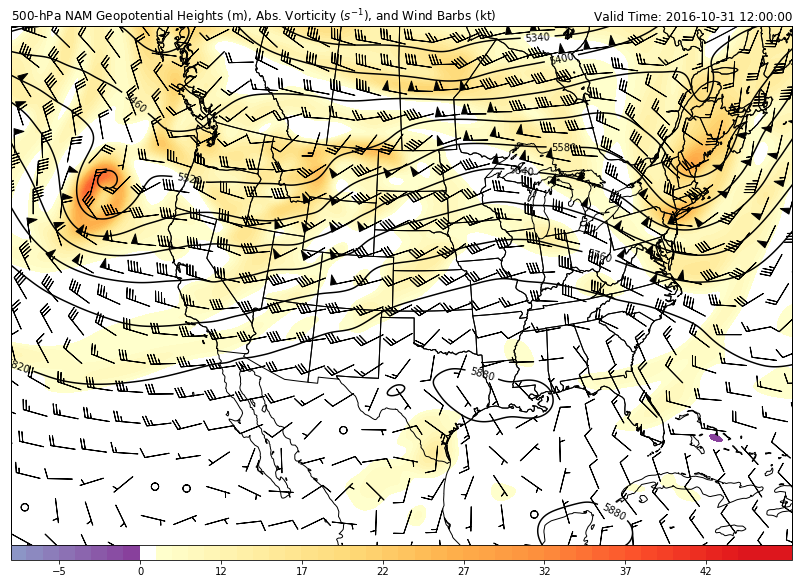

In [5]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Absolute Vorticity colors
# Use two different colormaps from matplotlib and combine into one color set
clevs_500_avor = list(range(-8, 1, 1))+list(range(8, 46, 1))
colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 48))
colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
colors = np.vstack((colors2, (1, 1, 1, 1), colors1))

# Plot absolute vorticity values (multiplying by 10^5 to scale appropriately)
cf = ax.contourf(lons, lats, avor_500*1e5, clevs_500_avor, colors=colors, extend='max',
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

# Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(0, 8000, 60)
cs = ax.contour(lons, lats, hght_500, clevs_500_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Set up a 2D slice to reduce the number of wind barbs plotted (every 20th)
wind_slice = (slice(None, None, 20), slice(None, None, 20))
ax.barbs(lons[wind_slice], lats[wind_slice],
         uwnd_500.to('kt')[wind_slice].m, vwnd_500[wind_slice].to('kt').m,
         pivot='middle', color='black', transform=datacrs)

# Plot two titles, one on right and left side
plt.title('500-hPa NAM Geopotential Heights (m), Abs. Vorticity ($s^{-1}$),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.savefig('500_hPa_Abs_Vorticity.png', dpi=150, bbox_inches='tight')
plt.show()